Using device: cuda (Mode: DINOv2 with 5 Slots)
Loading DINOv2 model...


Using cache found in /home/menserve/.cache/torch/hub/facebookresearch_dinov2_main
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Training (Target: 4000 steps for convergence)...
Step 0: Loss 6.373660
Step 500: Loss 0.927126
Visualizing with FIXED Hard Cases...


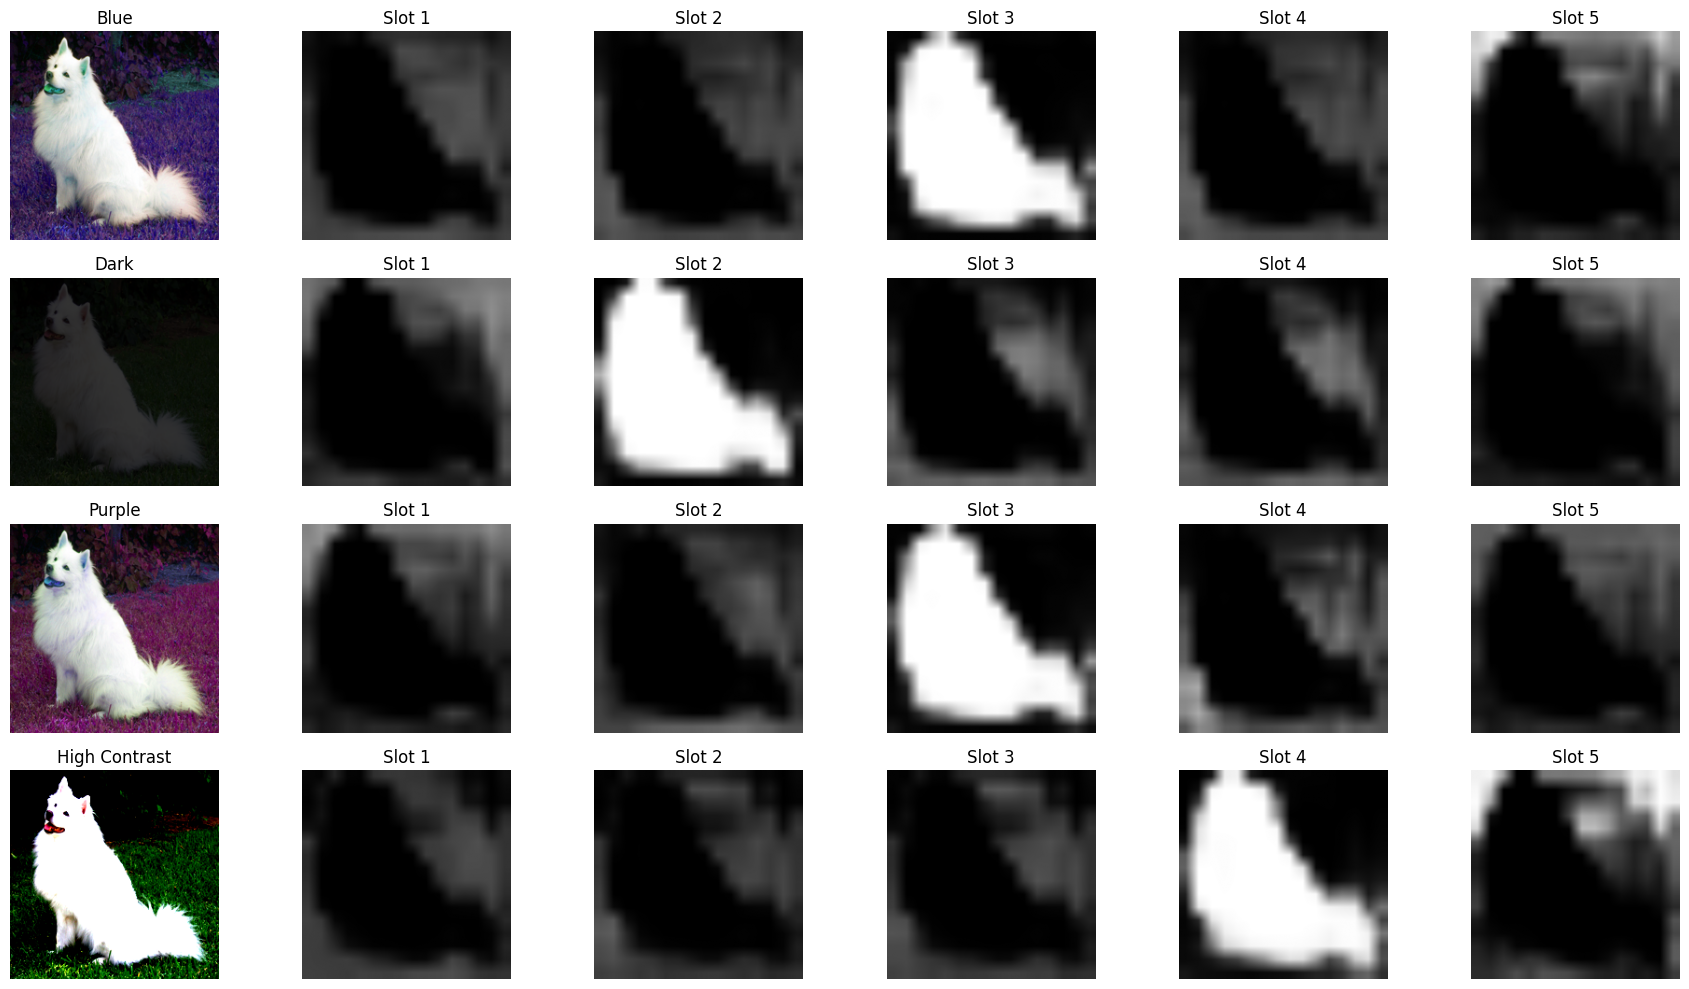

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 1. データセット (DINO用・色変化あり)
# ==========================================
class JitterDogDataset(Dataset):
    def __init__(self, resolution=(224, 224), length=10000):
        self.resolution = resolution
        self.length = length
        self.raw_img = self._load_dog_image()
        
        # 学習用: 激しいランダム色変化
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.5),
            transforms.ToTensor()
        ])

    def _load_dog_image(self):
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img.resize(self.resolution)
        except:
            print("Using noise (No Internet).")
            return Image.fromarray(np.uint8(np.random.rand(*self.resolution, 3)*255))

    def __getitem__(self, idx):
        return self.transform(self.raw_img)

    def __len__(self):
        return self.length

# ==========================================
# 2. DINOv2 Feature Extractor
# ==========================================
class DinoFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        print("Loading DINOv2 model...")
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        for param in self.dino.parameters():
            param.requires_grad = False
        self.dino.eval()

    def forward(self, x):
        # (B, 256, 384) -> (B, 384, 16, 16)
        features = self.dino.forward_features(x)["x_norm_patchtokens"]
        b, n, d = features.shape
        h = w = int(n**0.5) 
        features = features.permute(0, 2, 1).reshape(b, d, h, w)
        return features

# ==========================================
# 3. Slot Attention (5スロット対応)
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5
        self.norm_features = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, num_slots=None):
        inputs = self.norm_features(inputs)
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        
        slots = torch.randn(b, n_s, d, device=inputs.device)
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            
            # 温度係数を導入しないと、5スロットの場合に分離しにくいことがあります
            # 標準的な実装通り、ここでは暗黙的にTemperature=1.0ですが、
            # DINO特徴量は分散が大きいのでそのままで分離するはずです。
            attn = dots.softmax(dim=1) + 1e-8
            
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
        return slots

# ==========================================
# 4. Model (DINO-SAUR 5 Slots)
# ==========================================
class DinosauerModel(nn.Module):
    def __init__(self, num_slots=5): # ★デフォルトを5に変更
        super().__init__()
        self.feature_extractor = DinoFeatureExtractor()
        self.feat_dim = 384 
        self.num_slots = num_slots 
        
        self.pos_emb = nn.Parameter(torch.randn(1, 16, 16, self.feat_dim) * 0.05)
        
        # 5個に増えた分、少し表現力を上げるため hidden_dim を維持
        self.slot_attention = SlotAttention(num_slots, self.feat_dim, iters=5, hidden_dim=512)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(self.feat_dim + 2, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, self.feat_dim + 1, 3, padding=1)
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
        b, c, h, w = features.shape
        features_perm = features.permute(0, 2, 3, 1)
        features_pos = features_perm + self.pos_emb
        features_flat = features_pos.reshape(b, -1, c)
        
        slots = self.slot_attention(features_flat)
        
        slots_2d = slots.view(b * self.num_slots, self.feat_dim, 1, 1).repeat(1, 1, h, w)
        grid = self.build_grid(b * self.num_slots, (h, w), img.device)
        
        decode_in = torch.cat([slots_2d, grid], dim=1)
        out = self.decoder(decode_in)
        out = out.view(b, self.num_slots, self.feat_dim + 1, h, w)
        
        pred_feats = out[:, :, :self.feat_dim, :, :]
        masks = torch.softmax(out[:, :, self.feat_dim:, :, :], dim=1)
        
        recon_combined = torch.sum(pred_feats * masks, dim=1)
        return recon_combined, features, masks

# ==========================================
# 5. 実行: DINO vs 難敵 (5 Slots)
# ==========================================
def run_dino_5slots():
    torch.manual_seed(42) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Mode: DINOv2 with 5 Slots)")

    # ステップ数を稼ぐため、長めのデータセットに見せる
    dataset = JitterDogDataset(length=20000) 
    dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

    # ★ここを5に変更
    model = DinosauerModel(num_slots=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    print("Training (Target: 4000 steps for convergence)...")
    model.train()
    
    # ★学習時間を延ばします。これが灰色の解決策です。
    total_steps = 4000 
    
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_feat, target_feat, masks = model(batch)
        loss = ((target_feat - recon_feat)**2).mean()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Step {i}: Loss {loss.item():.6f}")
        if i >= total_steps:
            break

    # ==========================================
    # 可視化: 5個のスロットを並べる
    # ==========================================
    print("Visualizing with FIXED Hard Cases...")
    model.eval()
    
    raw_img = dataset.raw_img
    
    # 手動で「あの色」を作る
    img1 = TF.adjust_hue(raw_img, 0.45); img1 = TF.adjust_saturation(img1, 1.5) 
    img2 = TF.adjust_brightness(raw_img, 0.2)
    img3 = TF.adjust_hue(raw_img, -0.4); img3 = TF.adjust_saturation(img3, 1.5)
    img4 = TF.adjust_contrast(raw_img, 3.0)
    
    test_batch = torch.stack([
        transforms.ToTensor()(img1), transforms.ToTensor()(img2),
        transforms.ToTensor()(img3), transforms.ToTensor()(img4)
    ]).to(device)

    with torch.no_grad():
        _, _, masks = model(test_batch)

    def to_np(t): return t.permute(1, 2, 0).cpu().numpy().clip(0, 1)
    
    masks_resized = torch.nn.functional.interpolate(
        masks.view(-1, 1, 16, 16), 
        size=(224, 224), 
        mode='bilinear'
    ).view(4, 5, 224, 224) # ★ shape=(4, 5, 224, 224)
    
    def mask_to_np(m): return m.cpu().numpy()

    # ★ 5個のスロットを表示するために列数を増やす (Input + 5 Masks = 6列)
    fig, axes = plt.subplots(4, 6, figsize=(18, 10))
    titles = ["Blue", "Dark", "Purple", "High Contrast"]
    
    for row in range(4):
        # Input
        axes[row, 0].imshow(to_np(test_batch[row]))
        axes[row, 0].set_title(titles[row])
        axes[row, 0].axis('off')
        
        # Masks (5 slots)
        m_np = mask_to_np(masks_resized[row])
        for k in range(5):
            axes[row, k+1].imshow(m_np[k], cmap='gray', vmin=0, vmax=1)
            axes[row, k+1].set_title(f"Slot {k+1}")
            axes[row, k+1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dino_5slots()